# 1. Autores

<div style="display: flex; justify-content: center;">
  <table style="margin: auto; border-spacing: 60px;">
    <tr>
      <td align="center" style="padding: 20px;">
        <a href="https://github.com/PedroSampaioDias">
          <img style="border-radius: 50%;" src="https://avatars.githubusercontent.com/u/90795603?v=4" width="150px;"/>
          <h5 class="text-center">Pedro Sampaio - 211043745</h5>
        </a>
      </td>
      <td align="center" style="padding: 20px;">
        <a href="https://github.com/raulbreno">
          <img style="border-radius: 50%;" src="https://avatars.githubusercontent.com/u/72105072?v=4" width="150px;"/>
          <h5 class="text-center">Raul Breno - 200026810</h5>
        </a>
      </td>
    </tr>
  </table>
</div>


# 2. Abstract

# 3. Keywords

# 4. Introdução

O cerrado brasileiro possui uma grande diversidade de aves. Algumas delas apresentam um desenvolvimento cerebral maior que outras, como é o caso das aves da família Psittacidae. Diversas aves dessa família são conhecidas como papagaios, araras e periquitos.bEssas aves possuem inteligência superior em comparação às demais, sendo capazes de imitar diferentes sons. Caracterizam-se por um bico alto e curvo, com a parte superior maior que a inferior, além de apresentarem plumagens muito coloridas. Embora sejam bastante bonitas, podem ser difíceis de diferenciar a olho nu por pessoas que não possuem certas especializações. Com o objetivo de facilitar esse processo, a presente rede convolucional tem como finalidade analisar e identificar a espécie da ave a partir de uma imagem.

Para isso, será criada e treinada uma rede convolucional utilizando um conjunto de dados com mais de 3.000 imagens, obtidas a partir do site iNaturalist. O dataset possui diferentes quantidades de imagens para cada espécie e, a fim de equilibrar as classes, serão adicionadas novas imagens, além da aplicação de técnicas de data augmentation.

As especies a serem utilizadas no treinamento serão:

*   Amazona aestiva
*   Amazona amazonica
*   Anodorhynchus hyacinthinus
*   Ara ararauna
*   Ara chloropterus
*   Ara macao
*   Brotogeris chiriri
*   Diopsittaca nobilis
*   Eupsittula aurea
*   Forpus xanthopterygius
*   Orthopsittaca manilatus
*   Primolius maracana
*   Psittacara leucophthalmus
*   Touit melanonotus

Uma rede convolucional funciona a partir de três camadas principais: a camada convolucional, a camada de agrupamento e a camada totalmente conectada. A camada convolucional tem como objetivo dividir a imagem em regiões e aplicar filtros a partir de pesos aprendidos. A camada de agrupamento aplica um filtro sem pesos de treinamento na entrada, a fim de reduzir a quantidade de informações, mantendo apenas as mais relevantes. Por fim, a camada totalmente conectada realiza a classificação e retorna ao usuário a informação final.

A fim de comparar a rede criada, também será realizado o transfer learning a partir de uma arquitetura já consolidada, seguido do fine-tuning. Dessa forma, o resultado final compreenderá três redes convolucionais. A arquitetura utilizada para criar a rede convolucional será a ResNet50; para o transfer learning será empregada a XXXX; e, para o fine-tuning, será aplicada a técnica XXXX.

# 5. Trabalhos Relacionados

# 6. Metodologia

## 6.1 Imports

Esta célula faz o import das bibliotecas que serão utilizadas no notebook.


In [1]:
import gdown
import zipfile
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
import numpy as np
from fractions import Fraction
import random
import shutil
import cv2
from albumentations import Compose, HorizontalFlip, VerticalFlip, Rotate, CoarseDropout

## 6.2 Download do dataset original

Nesta etapa realizamos o processo completo de obtenção e organização do conjunto de dados.  
O arquivo compactado é baixado do Google Drive por meio da biblioteca **gdown**, armazenado em uma pasta de arquivos **compactados** e, em seguida, descompactado para a pasta **dataset_original**. Após a extração, diretórios e arquivos temporários do sistema (como `__MACOSX` e `.DS_Store`) são removidos, garantindo uma estrutura limpa e padronizada.  

Ao final, temos um dataset pronto para uso, organizado em `datasets/` e pronto para os próximos passos.


In [2]:
file_id = "19rWCGW38ht8TLY1ad7gba46mP5FCIZul"
url = f"https://drive.google.com/uc?id={file_id}"
zip_name = "dataset_original.zip"

base = Path("datasets"); compact = base/"compactados"; extract = base/"dataset_original"
base.mkdir(exist_ok=True); compact.mkdir(parents=True, exist_ok=True); extract.mkdir(parents=True, exist_ok=True)

exts = {".jpg",".jpeg",".png",".bmp",".tiff",".tif",".webp"}
contar_imgs = lambda p: sum(1 for f in p.rglob("*") if f.is_file() and f.suffix.lower() in exts)

def pronto(p):
    return p.exists() and sum(1 for d in p.iterdir() if d.is_dir()) == 14 and contar_imgs(p) == 2879

if pronto(extract):
    print("✅ Dataset já existe.")
else:
    print("📥 Baixando..."); gdown.download(url, zip_name, quiet=False)
    dest = compact/zip_name; dest.unlink(missing_ok=True); shutil.move(zip_name, dest)
    print("📂 Extraindo..."); zipfile.ZipFile(dest).extractall(extract)
    [shutil.rmtree(d, ignore_errors=True) for d in extract.rglob("__MACOSX")]
    [f.unlink(missing_ok=True) for f in extract.rglob(".DS_Store")]
    print(f"📸 Total de imagens: {contar_imgs(extract)}")
    print("✅ Dataset pronto em:", base.resolve())


✅ Dataset já existe.


## 6.3 Exploração de dados

### 6.3.1 Organização do dataset

In [3]:
dataset_path = "./datasets/dataset_original"

#### 6.3.1.1 Quantidade total de imagens

In [4]:
total_images = sum(len(files) for _, _, files in os.walk(dataset_path))
total_images

2879

#### 6.3.1.2 Número de classes (espécies)

In [5]:
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
num_classes = len(classes)
num_classes

14

### 6.3.2 Distribuição das classes

#### 6.3.2.1 Frequência de imagens por classe com representação em quantidade e porcentagem

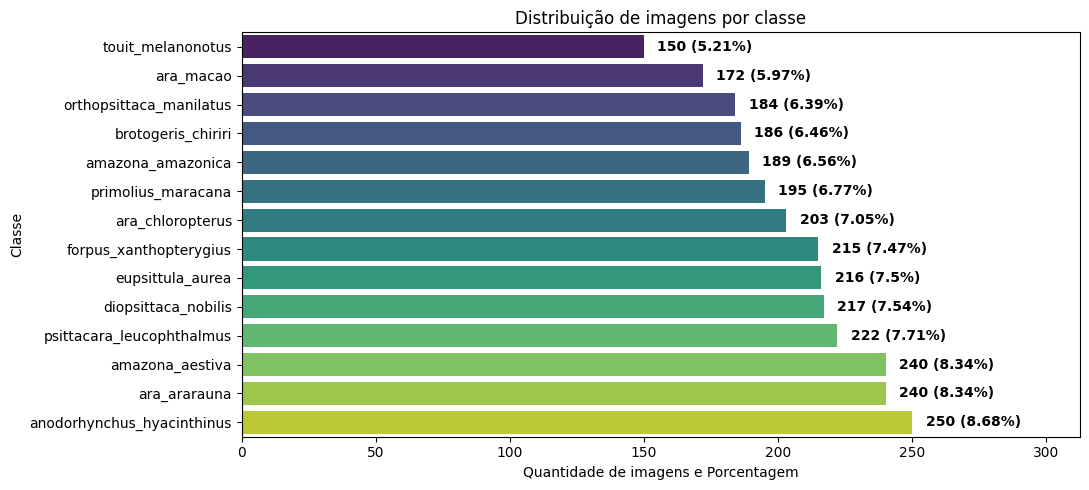

In [6]:
df = pd.DataFrame([
    (c, sum(1 for _,_,fs in os.walk(os.path.join(dataset_path, c))
            for f in fs if os.path.splitext(f)[1].lower() in exts))
    for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))
], columns=["classe","imagens"]).sort_values("imagens")

df["pct"] = (df["imagens"] / df["imagens"].sum() * 100).round(2)

plt.figure(figsize=(11,5))
ax = sns.barplot(data=df, x="imagens", y="classe",
                 hue="classe", dodge=False, palette="viridis",
                 orient="h", legend=False)

for i, p in enumerate(ax.patches):
    ax.text(p.get_width()+5, p.get_y()+p.get_height()/2,
            f"{int(p.get_width())} ({df['pct'].iloc[i]}%)",
            va="center", ha="left", weight="bold")

max_val = df["imagens"].max()
ax.set_xlim(0, max_val * 1.25)

ax.set(title="Distribuição de imagens por classe",
       xlabel="Quantidade de imagens e Porcentagem", ylabel="Classe")

plt.tight_layout()
plt.show()


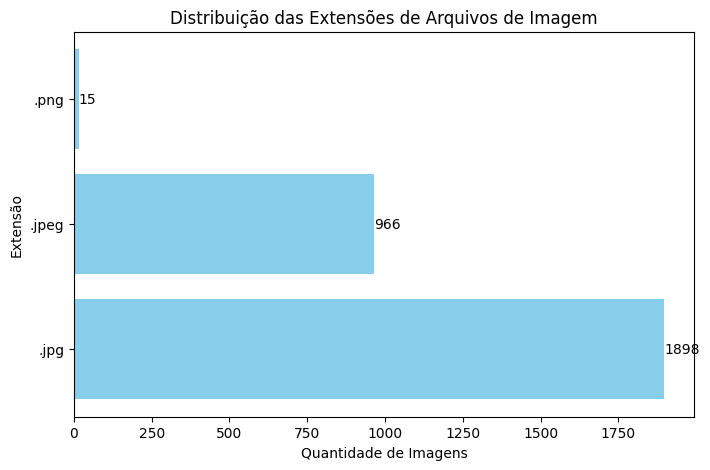

In [7]:
extensoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext:  # garante que tem extensão
            extensoes.append(ext)

# Conta as ocorrências de cada extensão
contagem = Counter(extensoes)

# Separa chaves e valores
extensoes_unicas = list(contagem.keys())
quantidades = list(contagem.values())

# Cria gráfico de barras horizontal
plt.figure(figsize=(8,5))
bars = plt.barh(extensoes_unicas, quantidades, color="skyblue")
plt.xlabel("Quantidade de Imagens")
plt.ylabel("Extensão")
plt.title("Distribuição das Extensões de Arquivos de Imagem")

# Adiciona os valores na frente das barras
for bar, qtd in zip(bars, quantidades):
    plt.text(qtd + 0.5, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center")

plt.show()

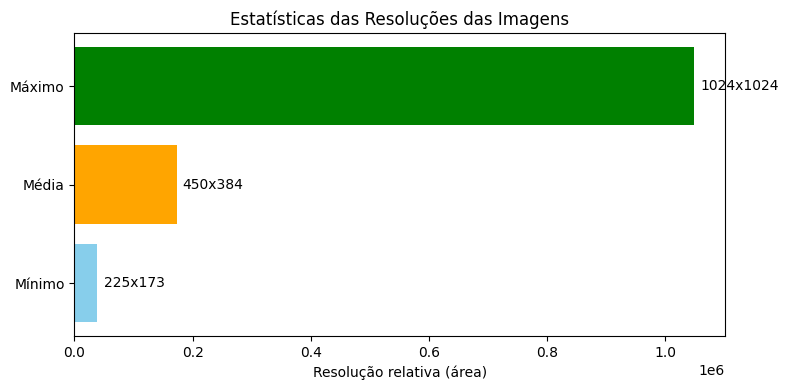

In [8]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append((w, h))
            except:
                pass

# Estatísticas
larguras = [w for w, h in resolucoes]
alturas = [h for w, h in resolucoes]

res_min = (min(larguras), min(alturas))
res_max = (max(larguras), max(alturas))
res_media = (int(np.mean(larguras)), int(np.mean(alturas)))

# Lista de barras com valores e rótulos
barras = [
    ("Mínimo", res_min),
    ("Média", res_media),
    ("Máximo", res_max)
]

# Ordena por largura*altura (área da imagem)
barras.sort(key=lambda x: x[1][0]*x[1][1])

# Extrai dados para plot
nomes = [nome for nome, res in barras]
res_labels = [f"{res[0]}x{res[1]}" for nome, res in barras]
valores = [res[0]*res[1] for nome, res in barras]  # usado só para tamanho da barra

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(range(len(nomes)), valores, color=["skyblue", "orange", "green"])
plt.yticks(range(len(nomes)), nomes)
plt.xlabel("Resolução relativa (área)")
plt.title("Estatísticas das Resoluções das Imagens")

# Adiciona rótulo [LxA] na frente de cada barra
for bar, label in zip(bars, res_labels):
    plt.text(bar.get_width() + max(valores)*0.01,
             bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()

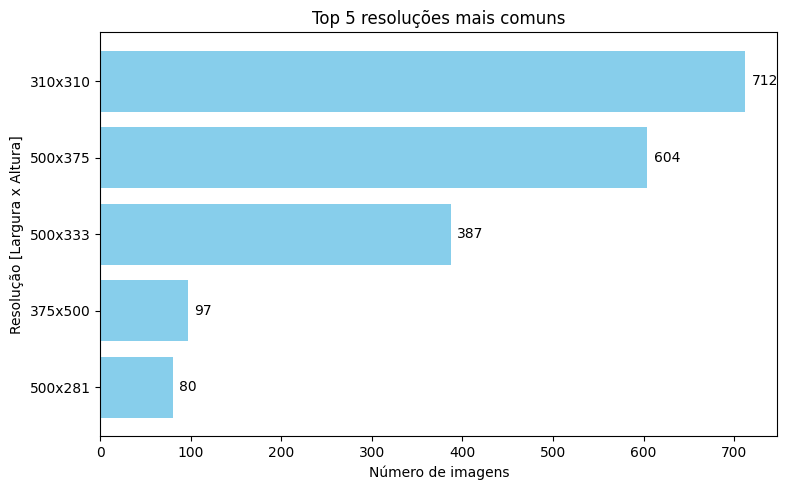

In [9]:
resolucoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    resolucoes.append(f"{w}x{h}")  # guarda como string "LxA"
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada resolução
contagem = Counter(resolucoes)

# Pega as 5 resoluções mais comuns
top5 = contagem.most_common(5)  # retorna lista de tuplas: [(resolucao, quantidade), ...]

# Separa em listas para plot
resolucoes_top5 = [item[0] for item in top5]
quantidades_top5 = [item[1] for item in top5]

# Cria gráfico horizontal
plt.figure(figsize=(8,5))
# inverte listas para colocar a maior barra em cima
bars = plt.barh(resolucoes_top5[::-1], quantidades_top5[::-1], color="skyblue")
plt.xlabel("Número de imagens")
plt.ylabel("Resolução [Largura x Altura]")
plt.title("Top 5 resoluções mais comuns")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top5[::-1]):
    plt.text(qtd + max(quantidades_top5)*0.01,
             bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [10]:

# Número total de resoluções únicas
total_resolucoes = len(contagem)
print(f"Número total de resoluções únicas: {total_resolucoes}")

Número total de resoluções únicas: 361


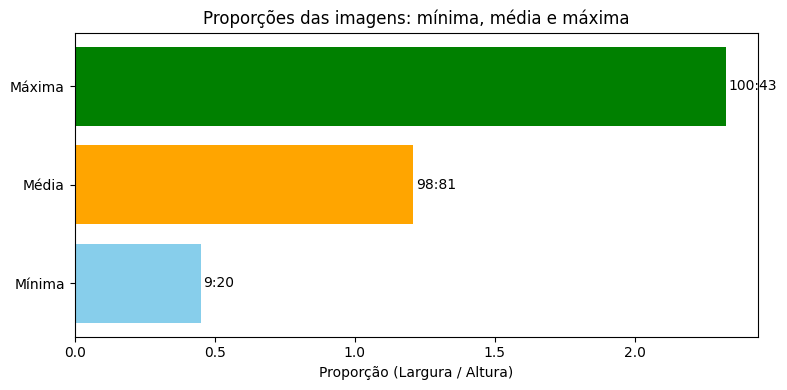

In [11]:
proporcoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    proporcao = Fraction(w, h).limit_denominator(100)  # simplifica a fração
                    proporcoes.append(proporcao)
            except:
                pass  # ignora arquivos corrompidos

# Calcula estatísticas
prop_min = min(proporcoes)
prop_max = max(proporcoes)
prop_media_decimal = np.mean([float(p) for p in proporcoes])
prop_media = Fraction(prop_media_decimal).limit_denominator(100)

# Lista para plot
barras = [
    ("Mínima", prop_min),
    ("Média", prop_media),
    ("Máxima", prop_max)
]

# Ordena por proporção decimal
barras.sort(key=lambda x: float(x[1]))

# Extrai dados para plot
nomes = [nome for nome, val in barras]
valores = [float(val) for nome, val in barras]
labels = [f"{val.numerator}:{val.denominator}" for nome, val in barras]  # rótulo L:A

# Cria gráfico horizontal
plt.figure(figsize=(8,4))
bars = plt.barh(nomes, valores, color=["skyblue", "orange", "green"])
plt.xlabel("Proporção (Largura / Altura)")
plt.title("Proporções das imagens: mínima, média e máxima")

# Adiciona rótulo L:A na frente da barra
for bar, label in zip(bars, labels):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             label, va="center", fontsize=10)

plt.tight_layout()
plt.show()

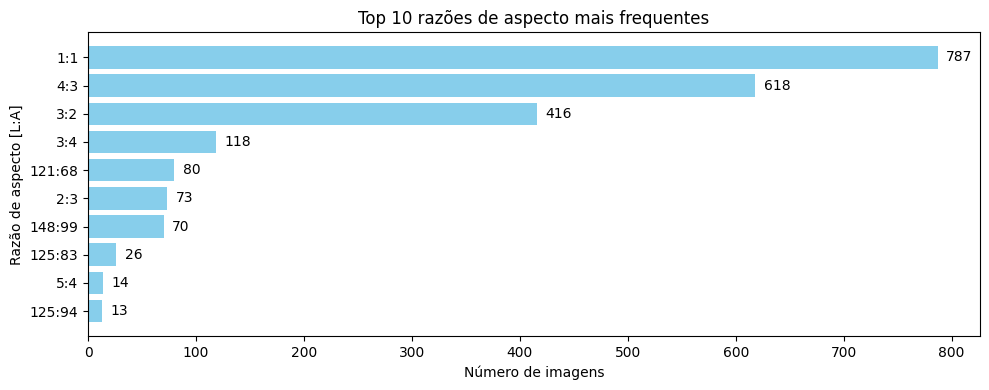

In [12]:
razoes = []

# Percorre todas as subpastas e arquivos
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"]:
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    w, h = img.size
                    razao = Fraction(w, h).limit_denominator(100)
                    razoes.append(f"{razao.numerator}:{razao.denominator}")
            except:
                pass  # ignora arquivos corrompidos

# Conta quantas imagens têm cada razão
contagem = Counter(razoes)

# Pega as 10 razões mais frequentes
top10 = contagem.most_common(10)  # lista de tuplas: [(razao, quantidade), ...]

# Separa em listas para plot
razoes_top10 = [item[0] for item in top10]
quantidades_top10 = [item[1] for item in top10]

# Cria gráfico horizontal
plt.figure(figsize=(10, max(4, len(razoes_top10)*0.4)))
bars = plt.barh(razoes_top10[::-1], quantidades_top10[::-1], color="skyblue")  # inverte para a mais frequente em cima
plt.xlabel("Número de imagens")
plt.ylabel("Razão de aspecto [L:A]")
plt.title("Top 10 razões de aspecto mais frequentes")

# Adiciona número de imagens na frente de cada barra
for bar, qtd in zip(bars, quantidades_top10[::-1]):
    plt.text(qtd + max(quantidades_top10)*0.01, bar.get_y() + bar.get_height()/2,
             str(qtd), va="center", fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
dataset_final_path = "./datasets/dataset_aumentado"

# Número alvo de imagens por classe
target_count = 300

# Cria pasta final
if not os.path.exists(dataset_final_path):
    os.makedirs(dataset_final_path)

# Funções de data augmentation usando Albumentations
def get_random_augmentation():
    # Escolhe aleatoriamente uma transformação
    aug_type = random.choice(["rotate", "flip", "cutout"])
    if aug_type == "rotate":
        return Compose([Rotate(limit=(10, 340), p=1)])
    elif aug_type == "flip":
        # Aleatoriamente escolhe flip horizontal ou vertical
        if random.random() > 0.5:
            return Compose([HorizontalFlip(p=1)])
        else:
            return Compose([VerticalFlip(p=1)])
    elif aug_type == "cutout":
        return Compose([CoarseDropout(
            max_holes=3, min_holes=1,
            max_height=0.2, min_height=0.1,
            max_width=0.2, min_width=0.1,
            fill_value=0, p=1
        )])

# Percorre todas as classes
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if not os.path.isdir(class_path):
        continue

    # Cria a pasta da classe no dataset final
    final_class_path = os.path.join(dataset_final_path, class_folder)
    os.makedirs(final_class_path, exist_ok=True)

    # Lista todas as imagens
    images = [f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    # Copia imagens originais para a pasta final
    for img_name in images:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(final_class_path, img_name))

    current_count = len(images)
    print(f"Classe '{class_folder}' tem {current_count} imagens. Processando...")

    # Gera imagens até atingir target_count
    while current_count < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(class_path, img_name)

        # Carrega imagem com OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Aplica uma transformação aleatória
        aug = get_random_augmentation()
        augmented = aug(image=img)['image']

        # Salva imagem final
        save_name = f"aug_{current_count}.jpg"
        save_path = os.path.join(final_class_path, save_name)
        augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
        cv2.imwrite(save_path, augmented_bgr)

        current_count += 1

    print(f"Classe '{class_folder}' finalizada com {current_count} imagens.")

print("Data augmentation concluído. Dataset final criado em 'dataset_final'.")

Classe 'psittacara_leucophthalmus' tem 222 imagens. Processando...
Classe 'psittacara_leucophthalmus' finalizada com 300 imagens.
Classe 'forpus_xanthopterygius' tem 215 imagens. Processando...


/tmp/ipykernel_41705/4006540478.py:23: UserWarning: Argument(s) 'max_holes, min_holes, max_height, min_height, max_width, min_width, fill_value' are not valid for transform CoarseDropout
  return Compose([CoarseDropout(


Classe 'forpus_xanthopterygius' finalizada com 300 imagens.
Classe 'anodorhynchus_hyacinthinus' tem 250 imagens. Processando...
Classe 'anodorhynchus_hyacinthinus' finalizada com 300 imagens.
Classe 'amazona_aestiva' tem 240 imagens. Processando...
Classe 'amazona_aestiva' finalizada com 300 imagens.
Classe 'touit_melanonotus' tem 150 imagens. Processando...
Classe 'touit_melanonotus' finalizada com 300 imagens.
Classe 'eupsittula_aurea' tem 216 imagens. Processando...
Classe 'eupsittula_aurea' finalizada com 300 imagens.
Classe 'diopsittaca_nobilis' tem 217 imagens. Processando...
Classe 'diopsittaca_nobilis' finalizada com 300 imagens.
Classe 'primolius_maracana' tem 195 imagens. Processando...
Classe 'primolius_maracana' finalizada com 300 imagens.
Classe 'amazona_amazonica' tem 189 imagens. Processando...
Classe 'amazona_amazonica' finalizada com 300 imagens.
Classe 'ara_chloropterus' tem 203 imagens. Processando...
Classe 'ara_chloropterus' finalizada com 300 imagens.
Classe 'ara_

In [14]:
"""!zip -r meus_arquivos.zip /content/datasets/dataset_final
from google.colab import files
files.download("meus_arquivos.zip")"""

'!zip -r meus_arquivos.zip /content/datasets/dataset_final\nfrom google.colab import files\nfiles.download("meus_arquivos.zip")'

## Trenamento

In [15]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import keras
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [16]:
data_dir = "./datasets/dataset_aumentado"

# Pastas de saída
train_dir = "./datasets/train_images"
test_dir = "./datasets/test_images"

# Criar as pastas de destino
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definir proporções
train_split = 0.8
test_split = 0.2

# Loop em cada subpasta (classe)
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Criar subpastas correspondentes em train/test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Listar imagens da classe
    images = os.listdir(class_path)
    random.shuffle(images)

    # Separar em 80% / 20%
    split_idx = int(len(images) * train_split)
    train_files = images[:split_idx]
    test_files = images[split_idx:]

    # Copiar arquivos
    for img in train_files:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(train_dir, class_name, img))
    for img in test_files:
        shutil.copy(os.path.join(class_path, img),
                    os.path.join(test_dir, class_name, img))

print("✅ Divisão concluída!")

✅ Divisão concluída!


In [17]:
"""!zip -r testImage.zip /content/datasets/test_images
from google.colab import files
files.download("testImage.zip")

!zip -r trainImage.zip /content/datasets/train_images
from google.colab import files
files.download("trainImage.zip")"""

'!zip -r testImage.zip /content/datasets/test_images\nfrom google.colab import files\nfiles.download("testImage.zip")\n\n!zip -r trainImage.zip /content/datasets/train_images\nfrom google.colab import files\nfiles.download("trainImage.zip")'

In [18]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. Definição dos parâmetros e caminhos
# ---
# A lista de nomes de classes que define a ordem dos rótulos
class_names = [
    "amazona_aestiva",
    "amazona_amazonica",
    "anodorhynchus_hyacinthinus",
    "ara_ararauna",
    "ara_chloropterus",
    "ara_macao",
    "brotogeris_chiriri",
    "diopsittaca_nobilis",
    "eupsittula_aurea",
    "forpus_xanthopterygius",
    "orthopsittaca_manilatus",
    "primolius_maracana",
    "psittacara_leucophthalmus",
    "touit_melanonotus",
]

# Defina o caminho base e os caminhos para os dados de treino e teste.
# **ATENÇÃO:** Você deve mudar estes caminhos para os caminhos reais em seu sistema.
BASE_PATH = './datasets'  # Assumindo que 'test_images' e 'train_images' estão no diretório atual
train_dir = os.path.join(BASE_PATH, 'train_images')
test_dir = os.path.join(BASE_PATH, 'test_images')

# Parâmetros para carregamento das imagens
IMAGE_SIZE = (128, 128) # Tamanho da imagem que será redimensionada
BATCH_SIZE = 32         # Número de imagens por batch durante o carregamento

# 2. Carregamento e Pré-processamento dos dados
# ---

print("Carregando dados de TREINO...")
# dataset de TREINO
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',                   # Rótulos inferidos pelo nome das subpastas
    label_mode='int',                    # Rótulos codificados como inteiros (0, 1, 2, ...)
    class_names=class_names,             # Garante a ordem correta das classes
    image_size=IMAGE_SIZE,               # Redimensiona todas as imagens
    interpolation='bilinear',
    shuffle=True,                        # Embaralha os dados de treino
    batch_size=BATCH_SIZE
)

print("\nCarregando dados de TESTE...")
# dataset de TESTE
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMAGE_SIZE,
    interpolation='bilinear',
    shuffle=False,                       # Não é necessário embaralhar dados de teste
    batch_size=BATCH_SIZE
)

# Pré-processamento: normalização dos valores de pixel para o intervalo [0, 1]
# A maioria dos modelos de aprendizado profundo espera esta normalização.
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


# 3. Conversão para Arrays NumPy (Vetores)
# ---

def dataset_to_numpy(dataset):
    """Converte um dataset de tf.data.Dataset em dois arrays NumPy (imagens e labels)."""
    images = []
    labels = []
    for img_batch, label_batch in dataset.unbatch().as_numpy_iterator():
        images.append(img_batch)
        labels.append(label_batch)

    # Empilha as listas para formar um único array NumPy
    if not images:
        print("Atenção: Nenhum dado encontrado no dataset.")
        return np.array([]), np.array([])

    return np.array(images), np.array(labels)

print("\nConvertendo datasets de treino para arrays NumPy...")
train_images, train_labels = dataset_to_numpy(train_ds)

print("Convertendo datasets de teste para arrays NumPy...")
test_images, test_labels = dataset_to_numpy(test_ds)


# 4. Exibição dos resultados e resumo
# ---
print("\n" + "="*50)
print("RESUMO DOS VETORES GERADOS")
print("="*50)
print(f"train_images (imagens de treino): {train_images.shape}")
print(f"train_labels (rótulos de treino): {train_labels.shape}")
print(f"test_images (imagens de teste): {test_images.shape}")
print(f"test_labels (rótulos de teste): {test_labels.shape}")
print(f"Tipo de dado das imagens: {train_images.dtype}")
print(f"Tipo de dado dos rótulos: {train_labels.dtype}")

# Verificação de um rótulo
if train_labels.size > 0:
    exemplo_label_idx = train_labels[0]
    nome_classe = class_names[exemplo_label_idx]
    print(f"\nExemplo: O primeiro rótulo ({exemplo_label_idx}) corresponde à classe: '{nome_classe}'")

2025-10-06 22:38:48.070888: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 22:38:48.096296: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Carregando dados de TREINO...
Found 6929 files belonging to 14 classes.


2025-10-06 22:38:48.717969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 22:38:48.922930: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1759801128.923971   41705 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9



Carregando dados de TESTE...
Found 3415 files belonging to 14 classes.

Convertendo datasets de treino para arrays NumPy...


2025-10-06 22:38:50.108703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Convertendo datasets de teste para arrays NumPy...

RESUMO DOS VETORES GERADOS
train_images (imagens de treino): (6929, 128, 128, 3)
train_labels (rótulos de treino): (6929,)
test_images (imagens de teste): (3415, 128, 128, 3)
test_labels (rótulos de teste): (3415,)
Tipo de dado das imagens: float32
Tipo de dado dos rótulos: int32

Exemplo: O primeiro rótulo (9) corresponde à classe: 'forpus_xanthopterygius'


2025-10-06 22:38:50.562511: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


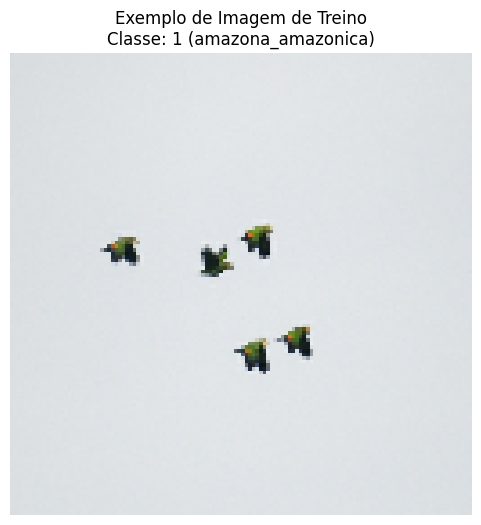

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Certifique-se de que 'class_names', 'train_images' e 'train_labels'
# foram definidos na célula anterior.

if train_images.size > 0:
    # 1. Seleciona a primeira imagem e seu rótulo
    primeira_imagem = train_images[3]
    primeiro_label_index = train_labels[3]

    # 2. Obtém o nome da classe
    nome_da_classe = class_names[primeiro_label_index]

    # 3. Plota a imagem
    plt.figure(figsize=(6, 6))

    # A imagem já está normalizada (entre 0 e 1), então ela pode ser exibida diretamente.
    plt.imshow(primeira_imagem)

    plt.title(f"Exemplo de Imagem de Treino\nClasse: {primeiro_label_index} ({nome_da_classe})")
    plt.axis('off') # Remove os eixos
    plt.show()

else:
    print("Os arrays de treino estão vazios. Verifique os caminhos dos diretórios na célula de carregamento.")

In [20]:
"""import tensorflow as tf

# Lista todos os dispositivos disponíveis (CPU e GPU)
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Configuração para que o TensorFlow aloque memória de forma dinâmica
        # Isso ajuda a evitar o erro "CUDNN_STATUS_ALLOC_FAILED"
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Define que o TensorFlow usará o primeiro dispositivo GPU encontrado
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        print("---")
        print("GPU CONFIGURADA COM SUCESSO!")
        print(f"Dispositivo GPU encontrado: {gpus[0].name}")
        print("---")

    except RuntimeError as e:
        # Erro de tempo de execução se a configuração for definida após a inicialização da GPU
        print(f"Erro ao configurar a GPU: {e}")

else:
    print("---")
    print("Nenhuma GPU (CUDA) detectada. O TensorFlow usará a CPU.")
    print("Verifique se os drivers NVIDIA, CUDA Toolkit e cuDNN estão instalados corretamente.")
    print("---")

# Exibe o dispositivo padrão onde as operações serão executadas
print(f"\nDispositivo padrão para execução: {tf.config.list_logical_devices()}")"""

'import tensorflow as tf\n\n# Lista todos os dispositivos disponíveis (CPU e GPU)\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\n\nif gpus:\n    try:\n        # Configuração para que o TensorFlow aloque memória de forma dinâmica\n        # Isso ajuda a evitar o erro "CUDNN_STATUS_ALLOC_FAILED"\n        for gpu in gpus:\n            tf.config.experimental.set_memory_growth(gpu, True)\n\n        # Define que o TensorFlow usará o primeiro dispositivo GPU encontrado\n        tf.config.experimental.set_visible_devices(gpus[0], \'GPU\')\n\n        print("---")\n        print("GPU CONFIGURADA COM SUCESSO!")\n        print(f"Dispositivo GPU encontrado: {gpus[0].name}")\n        print("---")\n\n    except RuntimeError as e:\n        # Erro de tempo de execução se a configuração for definida após a inicialização da GPU\n        print(f"Erro ao configurar a GPU: {e}")\n\nelse:\n    print("---")\n    print("Nenhuma GPU (CUDA) detectada. O TensorFlow usará a CPU.")\n    print("Verif

In [21]:
"""import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers ### ALTERAÇÃO ###
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

# ==============================================================================
# CONFIGURAÇÕES E HIPERPARÂMETROS
# ==============================================================================

# --- Parâmetros de Dados e Modelo ---
# Supondo que as variáveis train_images, train_labels, test_images, test_labels já foram carregadas
if 'train_images' in locals() and train_images.shape[0] > 0:
    INPUT_SHAPE = train_images.shape[1:]
else:
    INPUT_SHAPE = (224, 224, 3) # Shape padrão se os dados não estiverem carregados

CLASS_NAMES = ['Amazona aestiva', 'Amazona amazonica', 'Anodorhynchus hyacinthinus', 'Ara ararauna',
               'Ara chloropterus', 'Ara macao', 'Brotogeris chiriri', 'Diopsittaca nobilis',
               'Eupsittula aurea', 'Forpus xanthopterygius', 'Orthopsittaca manilatus',
               'Primolius maracana', 'Psittacara leucophthalmus', 'Touit melanonotus']
NUM_CLASSES = len(CLASS_NAMES)
MODEL_FILEPATH = 'melhor_modelo_vgg_style_l2.keras' # Mudei o nome para não sobrescrever

# --- Hiperparâmetros da Arquitetura ---
KERNEL_SIZE = (3, 3)
POOL_SIZE = (2, 2)
DENSE_UNITS = 512
DROPOUT_CONV = 0.35
DROPOUT_DENSE = 0.5
L2_FACTOR = 0.001  ### ALTERAÇÃO ### Fator para a regularização L2 (Weight Decay)

# --- Hiperparâmetros de Treinamento ---
OPTIMIZER = 'adam'
LOSS_FUNCTION = 'categorical_crossentropy'
BATCH_SIZE = 16
EPOCHS = 150

# --- Configurações dos Callbacks ---
MONITOR_METRIC = 'val_accuracy'
ES_PATIENCE = 10
RLR_PATIENCE = 3
RLR_FACTOR = 0.2
RLR_MIN_LR = 1e-6

# ==============================================================================
# PREPARAÇÃO DOS DADOS
# ==============================================================================

train_labels_one_hot = to_categorical(train_labels, NUM_CLASSES)
test_labels_one_hot = to_categorical(test_labels, NUM_CLASSES)

# ==============================================================================
# ARQUITETURA DO MODELO COM REGULARIZAÇÃO L2
# ==============================================================================

model = models.Sequential([
    # Bloco 1 (32 filtros)
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE, kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=POOL_SIZE),
    layers.Dropout(DROPOUT_CONV),

    # Bloco 2 (64 filtros)
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=POOL_SIZE),
    layers.Dropout(DROPOUT_CONV),

    # Bloco 3 (128 filtros)
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=POOL_SIZE),
    layers.Dropout(DROPOUT_CONV),

    # Bloco 4 (256 filtros)
    layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=POOL_SIZE),
    layers.Dropout(DROPOUT_CONV),

    # Classificador
    layers.Flatten(),
    layers.Dense(DENSE_UNITS, activation='relu', kernel_regularizer=regularizers.l2(L2_FACTOR)), ### ALTERAÇÃO ###
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_DENSE),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# ==============================================================================
# COMPILAÇÃO E CALLBACKS
# ==============================================================================

model.compile(optimizer=OPTIMIZER,
              loss=LOSS_FUNCTION,
              metrics=['accuracy'])

print("\nResumo do Modelo:")
model.summary()

# Callbacks... (código permanece o mesmo)
checkpoint_callback = ModelCheckpoint(filepath=MODEL_FILEPATH, monitor=MONITOR_METRIC, save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor=MONITOR_METRIC, patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=MONITOR_METRIC, factor=RLR_FACTOR, patience=RLR_PATIENCE, min_lr=RLR_MIN_LR, verbose=1)

# ==============================================================================
# TREINAMENTO
# ==============================================================================

print("\nIniciando Treinamento...")
history = model.fit(
    train_images,
    train_labels_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[checkpoint_callback, early_stopping, reduce_lr]
)

# ==============================================================================
# AVALIAÇÃO FINAL
# ==============================================================================

print(f"\nCarregando o melhor modelo salvo em '{MODEL_FILEPATH}'...")
best_model = models.load_model(MODEL_FILEPATH)

print("\nAvaliando o desempenho do MELHOR modelo no conjunto de teste:")
loss, accuracy = best_model.evaluate(test_images, test_labels_one_hot)

print(f"\n-> Acurácia do MELHOR modelo no conjunto de teste: {accuracy * 100:.2f}%")"""

'import tensorflow as tf\nfrom tensorflow.keras.utils import to_categorical\nfrom tensorflow.keras import models, layers, regularizers ### ALTERAÇÃO ###\nfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau\nimport numpy as np\n\n# ==============================================================================\n# CONFIGURAÇÕES E HIPERPARÂMETROS\n# ==============================================================================\n\n# --- Parâmetros de Dados e Modelo ---\n# Supondo que as variáveis train_images, train_labels, test_images, test_labels já foram carregadas\nif \'train_images\' in locals() and train_images.shape[0] > 0:\n    INPUT_SHAPE = train_images.shape[1:]\nelse:\n    INPUT_SHAPE = (224, 224, 3) # Shape padrão se os dados não estiverem carregados\n\nCLASS_NAMES = [\'Amazona aestiva\', \'Amazona amazonica\', \'Anodorhynchus hyacinthinus\', \'Ara ararauna\',\n               \'Ara chloropterus\', \'Ara macao\', \'Brotogeris chiriri\', \'Diop

In [22]:
"""best_model = models.load_model("/home/lab11/papagaio/papagaio-main/melhor_modelo_vgg_style_l2_1_88.64.keras")"""

'best_model = models.load_model("/home/lab11/papagaio/papagaio-main/melhor_modelo_vgg_style_l2_1_88.64.keras")'

In [23]:
"""import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ==============================================================================
# 1. FUNÇÃO PARA PLOTAR AS CURVAS DE TREINAMENTO
# ==============================================================================

def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Gráfico de Acurácia
    ax1.plot(history.history['accuracy'], label='Acurácia de Treino')
    ax1.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    ax1.set_title('Acurácia do Modelo', fontsize=16)
    ax1.set_xlabel('Época', fontsize=12)
    ax1.set_ylabel('Acurácia', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # Gráfico de Loss (Perda)
    ax2.plot(history.history['loss'], label='Loss de Treino')
    ax2.plot(history.history['val_loss'], label='Loss de Validação')
    ax2.set_title('Loss (Perda) do Modelo', fontsize=16)
    ax2.set_xlabel('Época', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================
# 2. ANÁLISE NO CONJUNTO DE TESTE (MATRIZ DE CONFUSÃO E RELATÓRIO)
# ==============================================================================

print("\nGerando previsões para o conjunto de teste...")
# Faz as previsões (retorna as probabilidades de cada classe)
y_pred_probs = best_model.predict(test_images)

# Converte as probabilidades para a classe com maior probabilidade
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Se os seus test_labels estiverem no formato one-hot, converta-os de volta.
# Se já estiverem como inteiros (0, 1, 2...), pode usar diretamente.
# Supondo que você tenha a variável `test_labels` original:
y_true = test_labels

# --- Relatório de Classificação ---
print("\n# ========================================= #")
print("#      RELATÓRIO DE CLASSIFICAÇÃO       #")
print("# ========================================= #\n")
print(classification_report(y_true, y_pred_classes, target_names=CLASS_NAMES))


# --- Matriz de Confusão ---
print("\nGerando a Matriz de Confusão...")
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)

plt.title('Matriz de Confusão', fontsize=20)
plt.ylabel('Classe Verdadeira', fontsize=15)
plt.xlabel('Classe Prevista', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o plot para caber tudo
plt.show()


# ==============================================================================
# CHAMADA DAS FUNÇÕES
# ==============================================================================
# Plota os gráficos de acurácia e loss
plot_history(history)"""

'import matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\nfrom sklearn.metrics import confusion_matrix, classification_report\n\n# ==============================================================================\n# 1. FUNÇÃO PARA PLOTAR AS CURVAS DE TREINAMENTO\n# ==============================================================================\n\ndef plot_history(history):\n\n    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))\n\n    # Gráfico de Acurácia\n    ax1.plot(history.history[\'accuracy\'], label=\'Acurácia de Treino\')\n    ax1.plot(history.history[\'val_accuracy\'], label=\'Acurácia de Validação\')\n    ax1.set_title(\'Acurácia do Modelo\', fontsize=16)\n    ax1.set_xlabel(\'Época\', fontsize=12)\n    ax1.set_ylabel(\'Acurácia\', fontsize=12)\n    ax1.legend(loc=\'lower right\')\n    ax1.grid(True)\n\n    # Gráfico de Loss (Perda)\n    ax2.plot(history.history[\'loss\'], label=\'Loss de Treino\')\n    ax2.plot(history.history[\'val_loss\'], label=\'Loss 

In [24]:
"""# TRANSFER LEARNING COM RESNET50
# Dataset separado em pastas: train / test
# ==========================================

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminhos do dataset
train_dir = "/home/lab11/papagaio/papagaio-main/datasets/train_images"
test_dir  = "/home/lab11/papagaio/papagaio-main/datasets/test_images"

# ================================
# 1. Geradores de dados
# ================================
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 2. Modelo base ResNet50
# ================================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congela as camadas da base (não treina elas)
for layer in base_model.layers:
    layer.trainable = False

# Número de classes detectadas automaticamente
num_classes = len(train_gen.class_indices)

# Cria o modelo final
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# ================================
# 3. Compilação e treino
# ================================
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    batch_size=32
)

# ================================
# 4. Avaliação e salvamento
# ================================
loss, acc = model.evaluate(test_gen)
print(f"\n✅ Acurácia final no conjunto de teste: {acc*100:.2f}%")

# Mostra classes detectadas
print("\nClasses detectadas:", list(train_gen.class_indices.keys()))

# Salva o modeloa
model.save("/content/modelo_resnet50_transfer.h5")
print("\n💾 Modelo salvo em /content/modelo_resnet50_transfer.h5")"""

'# TRANSFER LEARNING COM RESNET50\n# Dataset separado em pastas: train / test\n# ==========================================\n\nimport tensorflow as tf\nfrom tensorflow.keras.applications import ResNet50\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, GlobalAveragePooling2D\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n# Caminhos do dataset\ntrain_dir = "/home/lab11/papagaio/papagaio-main/datasets/train_images"\ntest_dir  = "/home/lab11/papagaio/papagaio-main/datasets/test_images"\n\n# ================================\n# 1. Geradores de dados\n# ================================\ntrain_datagen = ImageDataGenerator(rescale=1./255)\ntest_datagen  = ImageDataGenerator(rescale=1./255)\n\ntrain_gen = train_datagen.flow_from_directory(\n    train_dir,\n    target_size=(128, 128),\n    batch_size=32,\n    class_mode=\'categorical\',\n    shuffle=True\n)\n\ntest_gen = test_datagen.flow_from_directory(\n    test_dir,\n    targe

Classes detectadas (14): ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']
Iniciando treinamento com Vision Transformer...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.276253,1.922920,0.380966,0.619034,00:13
1,2.398438,1.261251,0.603221,0.396779,00:12
2,1.748238,0.852938,0.746999,0.253001,00:12
3,1.306788,0.602572,0.816691,0.183309,00:13
4,0.989201,0.445023,0.863250,0.136750,00:13
5,0.794097,0.348456,0.894583,0.105417,00:12
6,0.633508,0.268379,0.916837,0.083163,00:12
7,0.527482,0.229616,0.923865,0.076135,00:13
8,0.471642,0.189402,0.944363,0.055637,00:13
9,0.402696,0.163275,0.948170,0.051830,00:12


Better model found at epoch 0 with accuracy value: 0.38096633553504944.
Better model found at epoch 1 with accuracy value: 0.60322105884552.
Better model found at epoch 2 with accuracy value: 0.7469985485076904.
Better model found at epoch 3 with accuracy value: 0.8166910409927368.
Better model found at epoch 4 with accuracy value: 0.8632503747940063.
Better model found at epoch 5 with accuracy value: 0.8945827484130859.
Better model found at epoch 6 with accuracy value: 0.9168374538421631.
Better model found at epoch 7 with accuracy value: 0.9238653182983398.
Better model found at epoch 8 with accuracy value: 0.9443631172180176.
Better model found at epoch 9 with accuracy value: 0.9481698274612427.
Better model found at epoch 10 with accuracy value: 0.9595900177955627.
Better model found at epoch 12 with accuracy value: 0.9692533016204834.
Better model found at epoch 14 with accuracy value: 0.9754026532173157.
Better model found at epoch 15 with accuracy value: 0.9789165258407593.
Bet


✅ Treinamento concluído.
💾 O melhor modelo durante o treino foi salvo em: datasets/models/best_model_vit.pth
💾 Modelo final para inferência salvo em: /home/lab11/papagaio/modelo_vit_fastai.pkl


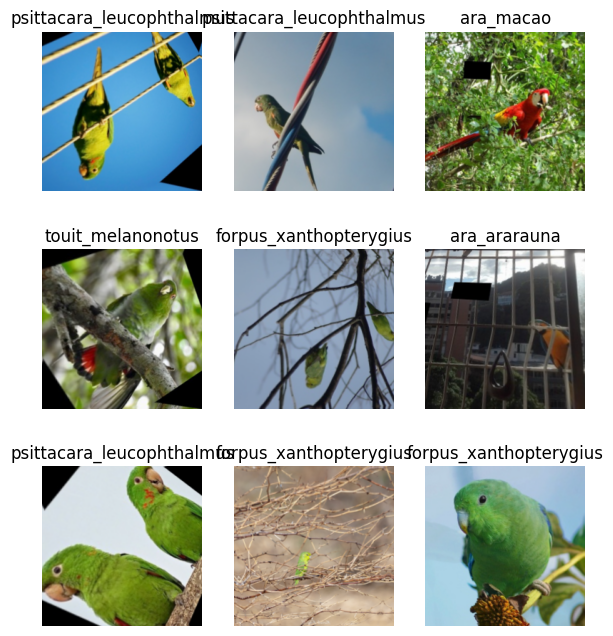

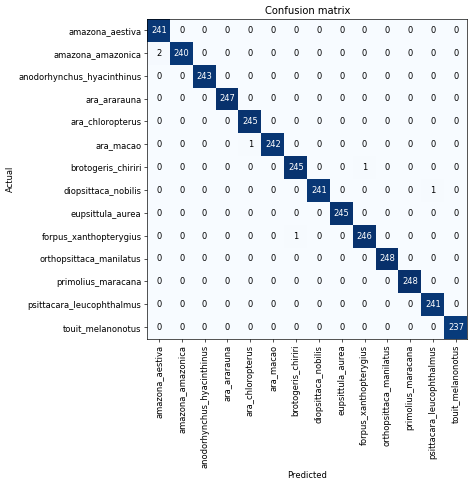

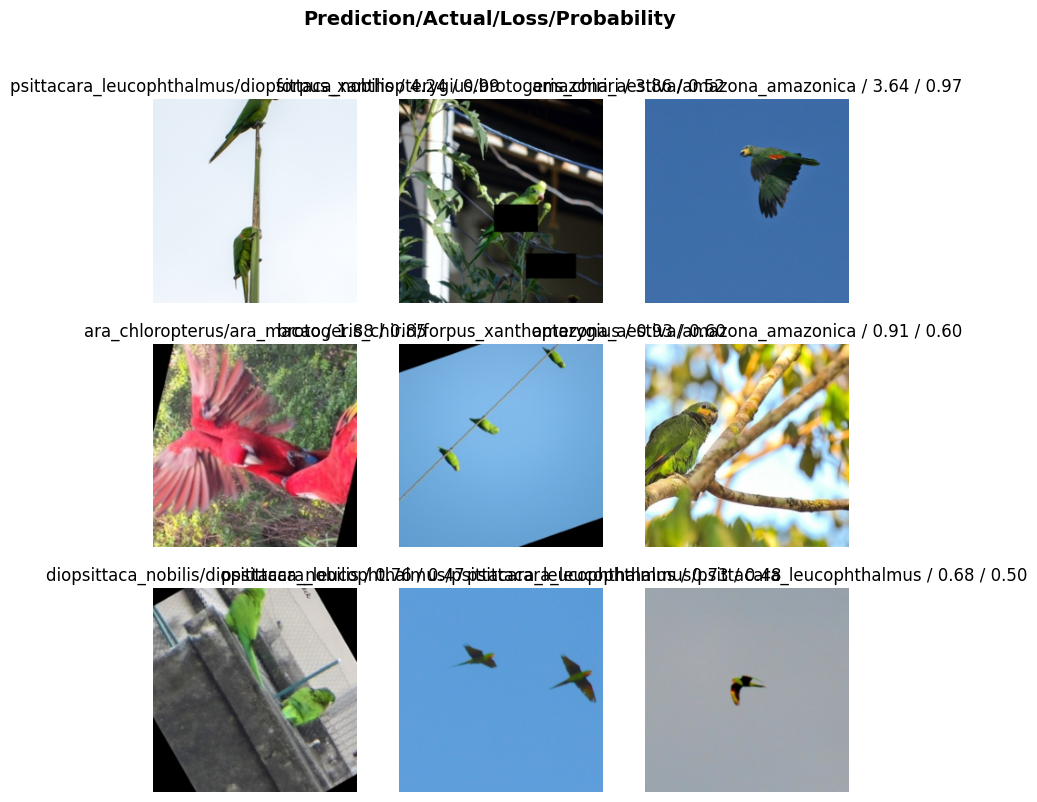

In [28]:
import os
from pathlib import Path
from fastai.vision.all import *
import timm

# =========================
# 1) Caminhos e parâmetros
# =========================
BASE_PATH = Path('./datasets')
train_dir_name = 'train_images'
test_dir_name = 'test_images'

# ** AQUI ESTÁ A CORREÇÃO FINAL **
IMG_SIZE = 224 # Ajustado para corresponder ao modelo ViT
BATCH_SIZE = 64 # Se tiver erro de memória (CUDA out of memory), reduza para 32 ou 16
LEARNING_RATE = 2e-3
EPOCHS = 100

# =========================
# 2) Datasets
# =========================
dls = ImageDataLoaders.from_folder(
    BASE_PATH,
    train=train_dir_name,
    valid=test_dir_name,
    item_tfms=Resize(IMG_SIZE), # Agora vai redimensionar para 224x224
    batch_tfms=aug_transforms(),
    bs=BATCH_SIZE
)

num_classes = len(dls.vocab)
print(f"Classes detectadas ({num_classes}): {dls.vocab}")
dls.show_batch(max_n=9, figsize=(7,8))

# =========================
# 3) Modelo
# =========================
learn = vision_learner(
    dls,
    'vit_small_patch16_224',
    metrics=[accuracy, error_rate]
)

# =========================
# 4) Callbacks
# =========================
callbacks = [
    EarlyStoppingCallback(
        monitor='accuracy',
        patience=10,
        min_delta=0.001
    ),
    SaveModelCallback(
        monitor='accuracy',
        fname='best_model_vit'
    )
]

# =========================
# 5) Treino
# =========================
print("Iniciando treinamento com Vision Transformer...")
learn.fit_one_cycle(
    EPOCHS,
    lr_max=LEARNING_RATE,
    cbs=callbacks
)

# =========================
# 6) Avaliação e salvamento
# =========================
print("\nAnalisando resultados...")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)
interp.plot_top_losses(9, nrows=3)

final_model_path = "/home/lab11/papagaio/modelo_vit_fastai.pkl"
learn.export(final_model_path)

print(f"\n✅ Treinamento concluído.")
print(f"💾 O melhor modelo durante o treino foi salvo em: {learn.path/learn.model_dir}/best_model_vit.pth")
print(f"💾 Modelo final para inferência salvo em: {final_model_path}")

In [29]:
# =======================================================
# 6.1) EXIBIR A ACURÁCIA DE VALIDAÇÃO FINAL (NOVO CÓDIGO)
# =======================================================
# O EarlyStoppingCallback já restaurou o melhor modelo.
# Agora, vamos rodar `validate()` para ver as métricas exatas desse melhor modelo.
print("\nCalculando métricas finais do melhor modelo no conjunto de validação...")
final_metrics = learn.validate()

# A ordem das métricas em `final_metrics` é: [valid_loss, accuracy, error_rate]
# Pegamos o segundo item (índice 1) que é a acurácia.
final_accuracy = final_metrics[1]
print(f"\n{'='*30}")
print(f"  Acurácia Final de Validação: {final_accuracy*100:.4f}%")
print(f"{'='*30}\n")


# =========================
# 6.2) Salvamento do modelo
# =========================
final_model_path = "/home/lab11/papagaio/modelo_vit_fastai.pkl"
learn.export(final_model_path)

print(f"✅ Treinamento concluído.")
print(f"💾 O melhor modelo durante o treino foi salvo em: {learn.path/learn.model_dir}/best_model_vit.pth")
print(f"💾 Modelo final para inferência salvo em: {final_model_path}")



Calculando métricas finais do melhor modelo no conjunto de validação...



  Acurácia Final de Validação: 99.8243%

✅ Treinamento concluído.
💾 O melhor modelo durante o treino foi salvo em: datasets/models/best_model_vit.pth
💾 Modelo final para inferência salvo em: /home/lab11/papagaio/modelo_vit_fastai.pkl


# 7. Resultados

In [30]:
learn.export("./modelo_vit.pkl")

Classes detectadas (14): ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']
Iniciando treinamento com ResNet50 e Fine-Tuning...


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,3.437681,2.085913,0.334993,0.665007,00:15


Better model found at epoch 0 with accuracy value: 0.3349926769733429.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.816743,1.953290,0.368668,0.631332,00:17
1,2.707668,1.841847,0.399122,0.600878,00:18
2,2.558429,1.726859,0.440703,0.559297,00:17
3,2.451080,1.649009,0.463543,0.536457,00:18
4,2.328768,1.549094,0.497804,0.502196,00:18
5,2.277719,1.474307,0.517716,0.482284,00:18
6,2.122583,1.395689,0.543485,0.456515,00:18
7,2.056529,1.305102,0.573646,0.426354,00:17
8,1.960219,1.234944,0.595315,0.404685,00:18
9,1.874943,1.161961,0.619912,0.380088,00:18


Better model found at epoch 0 with accuracy value: 0.3686676323413849.
Better model found at epoch 1 with accuracy value: 0.3991215229034424.
Better model found at epoch 2 with accuracy value: 0.44070279598236084.
Better model found at epoch 3 with accuracy value: 0.46354320645332336.
Better model found at epoch 4 with accuracy value: 0.49780380725860596.
Better model found at epoch 5 with accuracy value: 0.5177159309387207.
Better model found at epoch 6 with accuracy value: 0.543484628200531.
Better model found at epoch 7 with accuracy value: 0.5736456513404846.
Better model found at epoch 8 with accuracy value: 0.5953148007392883.
Better model found at epoch 9 with accuracy value: 0.6199121475219727.
Better model found at epoch 10 with accuracy value: 0.6407027840614319.
Better model found at epoch 11 with accuracy value: 0.6685212254524231.
Better model found at epoch 12 with accuracy value: 0.6790629625320435.
Better model found at epoch 13 with accuracy value: 0.7077598571777344.



✅ Treinamento com Fine-Tuning concluído.
💾 O melhor modelo durante o treino foi salvo em: datasets/models/best_model_resnet50_finetuned.pth
💾 Modelo final para inferência salvo em: /home/lab11/papagaio/modelo_resnet50_finetuned_fastai.pkl


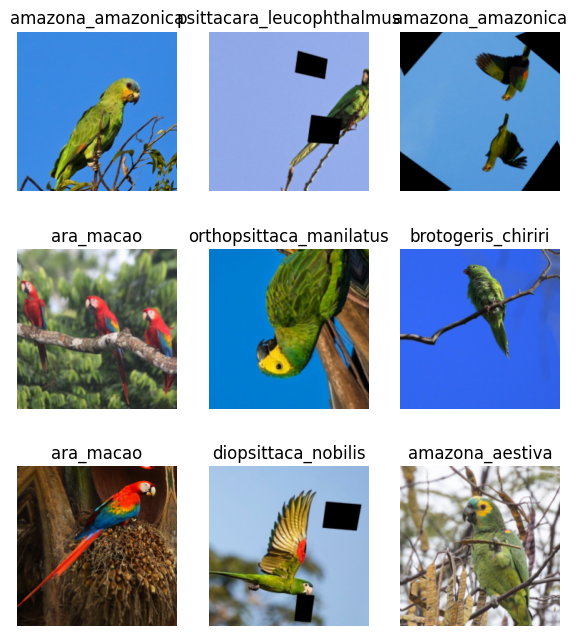

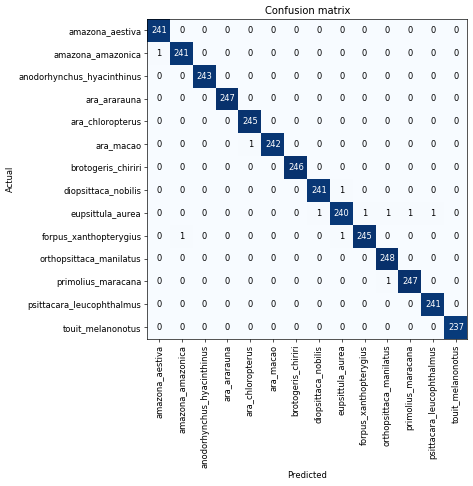

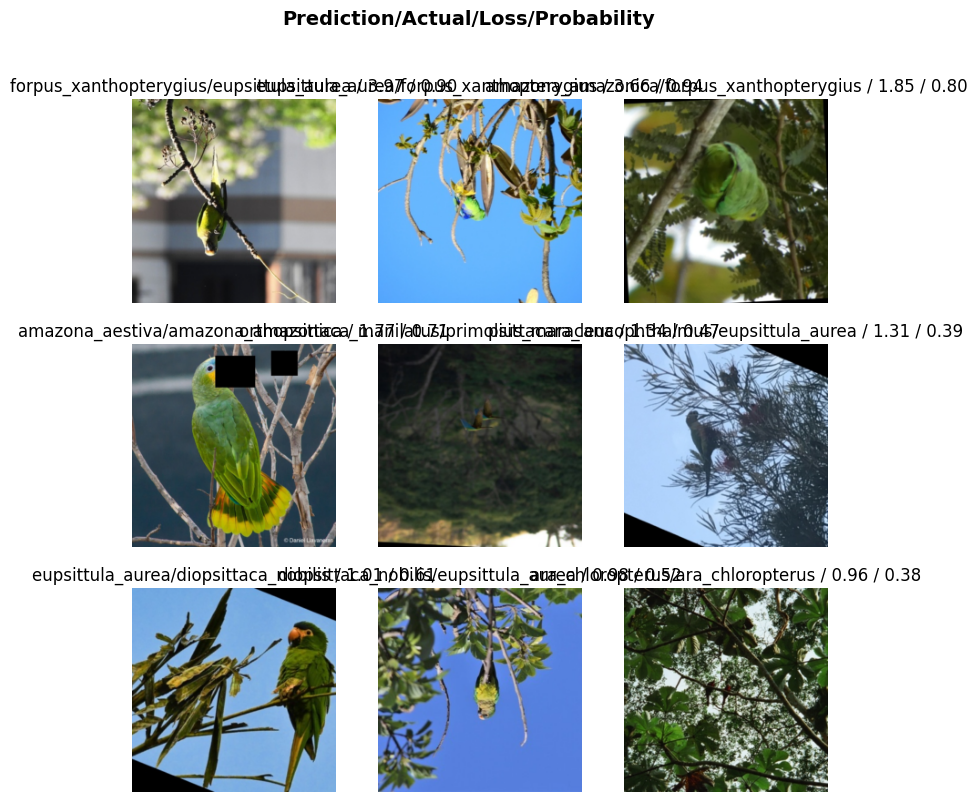

In [32]:
import os
from pathlib import Path
from fastai.vision.all import *
import timm

# =========================
# 1) Caminhos e parâmetros
# =========================
BASE_PATH = Path('./datasets')
train_dir_name = 'train_images'
test_dir_name = 'test_images'

IMG_SIZE = 224
BATCH_SIZE = 64
# NOTA: Para o fine_tune, a taxa de aprendizado da cabeça pode ser diferente
# da taxa de aprendizado do corpo. Vamos manter essa para a cabeça.
HEAD_LEARNING_RATE = 2e-3
EPOCHS = 150 # Um número razoável de épocas para o fine-tuning. EarlyStopping vai cuidar do resto.

# =========================
# 2) Datasets
# =========================
dls = ImageDataLoaders.from_folder(
    BASE_PATH,
    train=train_dir_name,
    valid=test_dir_name,
    item_tfms=Resize(IMG_SIZE),
    batch_tfms=aug_transforms(),
    bs=BATCH_SIZE
)

num_classes = len(dls.vocab)
print(f"Classes detectadas ({num_classes}): {dls.vocab}")
dls.show_batch(max_n=9, figsize=(7,8))

# =========================
# 3) Modelo
# =========================
learn = vision_learner(
    dls,
    resnet50,
    metrics=[accuracy, error_rate],
    # Definimos o learning rate padrão para o otimizador
    lr=HEAD_LEARNING_RATE
)

# =========================
# 4) Callbacks
# =========================
callbacks = [
    EarlyStoppingCallback(
        monitor='accuracy',
        patience=10,
        min_delta=0.001
    ),
    SaveModelCallback(
        monitor='accuracy',
        fname='best_model_resnet50_finetuned' # Novo nome para o modelo com fine-tuning
    )
]

# =======================================================
# 5) Treino com FINE-TUNING (A GRANDE MUDANÇA ESTÁ AQUI)
# =======================================================
print("Iniciando treinamento com ResNet50 e Fine-Tuning...")

# Dica: Antes de rodar o fine_tune, é uma boa prática rodar o buscador de taxa de aprendizado
# learn.lr_find()
# Isso te ajudaria a escolher o melhor `base_lr`. Vamos usar um valor seguro.
BASE_LR_BODY = 1e-4 # Taxa de aprendizado para o corpo do modelo (mais baixa)

learn.fine_tune(
    EPOCHS, # Número de épocas para treinar o modelo inteiro (descongelado)
    base_lr=BASE_LR_BODY, # Taxa de aprendizado para as camadas congeladas
    cbs=callbacks
)


# =========================
# 6) Avaliação e salvamento
# =========================
print("\nAnalisando resultados...")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)
interp.plot_top_losses(9, nrows=3)

final_model_path = "/home/lab11/papagaio/modelo_resnet50_finetuned_fastai.pkl"
learn.export(final_model_path)

print(f"\n✅ Treinamento com Fine-Tuning concluído.")
print(f"💾 O melhor modelo durante o treino foi salvo em: {learn.path/learn.model_dir}/best_model_resnet50_finetuned.pth")
print(f"💾 Modelo final para inferência salvo em: {final_model_path}")

Carregando modelo de: /home/lab11/papagaio/papagaio-main/modelo_resnet50_finetuned_fastai.pkl
Modelo carregado com sucesso!

Fazendo previsão na imagem: /home/lab11/papagaio/papagaio-main/image copy 3.png


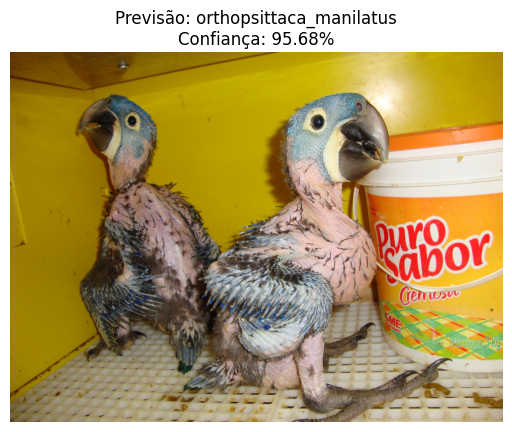


      RESULTADO DA CLASSIFICAÇÃO
A imagem foi classificada como: 'orthopsittaca_manilatus'

Top 5 probabilidades:
1. orthopsittaca_manilatus: 95.68%
2. amazona_aestiva: 1.92%
3. anodorhynchus_hyacinthinus: 1.44%
4. diopsittaca_nobilis: 0.45%
5. ara_ararauna: 0.38%


In [44]:
from fastai.vision.all import *
from PIL import Image
import matplotlib.pyplot as plt
import pathlib

# Para evitar um erro comum no Windows
# temp = pathlib.PosixPath
# pathlib.PosixPath = pathlib.WindowsPath

# ===================================================================
# 1. CONFIGURE OS CAMINHOS AQUI
# ===================================================================

# Altere esta linha para o caminho exato onde seu modelo .pkl foi salvo.
# Exemplo: "/home/lab11/papagaio/modelo_resnet50_finetuned_fastai.pkl"
caminho_do_modelo = "/home/lab11/papagaio/papagaio-main/modelo_resnet50_finetuned_fastai.pkl"  # <--- MUDE AQUI

# Altere esta linha para o caminho da imagem que você quer classificar.
# Exemplo: "imagens/teste/pardal_01.jpg"
caminho_da_imagem = "/home/lab11/papagaio/papagaio-main/image copy 3.png"  # <--- MUDE AQUI

# ===================================================================
# 2. FUNÇÃO PARA CARREGAR O MODELO E PREVER A IMAGEM
# ===================================================================

def prever_imagem(caminho_modelo, caminho_imagem):
    """
    Carrega um modelo treinado da fastai e faz a previsão em uma única imagem.
    """
    # ---- Carregamento do Modelo ----
    try:
        print(f"Carregando modelo de: {caminho_modelo}")
        # load_learner carrega tudo o que é necessário para a inferência
        learn = load_learner(caminho_modelo)
        print("Modelo carregado com sucesso!")
    except FileNotFoundError:
        print(f"ERRO: Arquivo do modelo não encontrado em '{caminho_modelo}'. Verifique o caminho.")
        return
    except Exception as e:
        print(f"Ocorreu um erro ao carregar o modelo: {e}")
        return

    # ---- Previsão na Imagem ----
    try:
        print(f"\nFazendo previsão na imagem: {caminho_imagem}")
        
        # O método .predict faz todo o processamento necessário na imagem
        classe_predita, _, probabilidades = learn.predict(caminho_imagem)
        
        # Exibe a imagem com o resultado
        img = Image.open(caminho_imagem)
        plt.imshow(img)
        # Pega a probabilidade da classe prevista
        prob_max = probabilidades.max()
        plt.title(f"Previsão: {classe_predita}\nConfiança: {prob_max*100:.2f}%")
        plt.axis('off')
        plt.show()

        # ---- Mostra o resultado detalhado no terminal ----
        print("\n" + "="*40)
        print("      RESULTADO DA CLASSIFICAÇÃO")
        print("="*40)
        print(f"A imagem foi classificada como: '{classe_predita}'")
        
        # Mostra o top 5 de probabilidades para ter mais detalhes
        print("\nTop 5 probabilidades:")
        # Combina os nomes das classes (vocab) com suas probabilidades
        prob_por_classe = sorted(zip(learn.dls.vocab, probabilidades), key=lambda x: x[1], reverse=True)
        for i, (classe, prob) in enumerate(prob_por_classe[:5]):
            print(f"{i+1}. {classe}: {prob*100:.2f}%")

    except FileNotFoundError:
        print(f"ERRO: Arquivo de imagem não encontrado em '{caminho_imagem}'. Verifique o caminho.")
    except Exception as e:
        print(f"Ocorreu um erro durante a previsão: {e}")


# ===================================================================
# 3. EXECUÇÃO PRINCIPAL
# ===================================================================
if __name__ == '__main__':
    prever_imagem(caminho_do_modelo, caminho_da_imagem)

In [51]:
from fastai.vision.all import *
from pathlib import Path
import collections

# ===================================================================
# 1) CAMINHOS
# ===================================================================
caminho_do_modelo = "/home/lab11/papagaio/papagaio-main/modelo_resnet50_finetuned_fastai.pkl"
caminho_teste     = "/home/lab11/papagaio/papagaio-main/datasets/test_images"

# (Opcional) classes que você informou; usaremos APENAS para validar nomes/pastas
class_names = [
    "amazona_aestiva",
    "amazona_amazonica",
    "anodorhynchus_hyacinthinus",
    "ara_ararauna",
    "ara_chloropterus",
    "ara_macao",
    "brotogeris_chiriri",
    "diopsittaca_nobilis",
    "eupsittula_aurea",
    "forpus_xanthopterygius",
    "orthopsittaca_manilatus",
    "primolius_maracana",
    "psittacara_leucophthalmus",
    "touit_melanonotus",
]

# ===================================================================
# 2) FUNÇÃO
# ===================================================================
def avaliar_modelo_no_teste(caminho_modelo, caminho_teste, class_names=None):
    # 1) Carrega o modelo
    print(f"Carregando modelo de: {caminho_modelo}")
    learn = load_learner(caminho_modelo)
    print("✅ Modelo carregado com sucesso!\n")

    if not hasattr(learn.dls, "vocab") or learn.dls.vocab is None:
        raise RuntimeError("Este Learner não tem 'vocab' — o modelo provavelmente não é de classificação.")

    vocab = list(map(str, learn.dls.vocab))
    print("🔠 Vocab do modelo:", vocab)

    # 2) Valida classes (opcional)
    if class_names is not None:
        print("🔤 Labels fornecidas:", class_names)
        if set(class_names) != set(vocab):
            faltando = [c for c in vocab if c not in class_names]
            extras   = [c for c in class_names if c not in vocab]
            raise RuntimeError(
                "As classes do modelo e as fornecidas diferem.\n"
                f"Faltando no seu 'class_names': {faltando}\n"
                f"Extras no seu 'class_names': {extras}"
            )

    # 3) Coleta arquivos do teste e rótulos a partir da subpasta
    base = Path(caminho_teste)
    if not base.exists():
        raise FileNotFoundError(f"Pasta de teste não encontrada: {base}")

    files = get_image_files(base)
    if len(files) == 0:
        raise RuntimeError("Nenhuma imagem encontrada no conjunto de teste.")

    # Filtra só arquivos cujas pastas são classes válidas
    valid_classes = set(vocab)
    files = [f for f in files if f.parent.name in valid_classes]

    if len(files) == 0:
        raise RuntimeError("As imagens não estão em subpastas com nomes de classes do modelo.")

    # Contagem por classe (diagnóstico)
    contagem = collections.Counter(f.parent.name for f in files)
    print("📦 Imagens por classe no teste:", dict(contagem))
    print(f"📦 Total de imagens no teste: {len(files)}")

    # 4) Monta rótulos verdadeiros (targs) como índices do vocab
    cls2idx = {c:i for i,c in enumerate(vocab)}
    targs_idx = tensor([cls2idx[f.parent.name] for f in files]).long()

    # 5) Cria um test_dl **sem** rótulos (apenas itens). Isso evita o erro de tuplas.
    test_dl = learn.dls.test_dl(files)  # sem with_labels

    # 6) Predições e acurácia manual
    print("Calculando predições...")
    preds = learn.get_preds(dl=test_dl)[0]  # só preds; targs vazio pq não há labels no dl
    pred_idx = preds.argmax(dim=1)

    acc = (pred_idx == targs_idx).float().mean()
    print(f"\n📊 Acurácia no conjunto de teste: {acc.item()*100:.2f}%")

    # (Opcional) mostra matriz de confusão rapidamente
    try:
        from fastai.metrics import ConfusionMatrix
        cm = ConfusionMatrix()
        cm.add(pred_idx, targs_idx)
        print("\nMatriz de confusão (primeiras linhas):")
        print(cm[:min(10, len(vocab)), :min(10, len(vocab))])  # evita imprimir gigante
    except Exception:
        pass

    return acc.item()

# ===================================================================
# 3) EXECUÇÃO
# ===================================================================
if __name__ == '__main__':
    avaliar_modelo_no_teste(caminho_do_modelo, caminho_teste, class_names=class_names)


Carregando modelo de: /home/lab11/papagaio/papagaio-main/modelo_resnet50_finetuned_fastai.pkl
✅ Modelo carregado com sucesso!

🔠 Vocab do modelo: ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']
🔤 Labels fornecidas: ['amazona_aestiva', 'amazona_amazonica', 'anodorhynchus_hyacinthinus', 'ara_ararauna', 'ara_chloropterus', 'ara_macao', 'brotogeris_chiriri', 'diopsittaca_nobilis', 'eupsittula_aurea', 'forpus_xanthopterygius', 'orthopsittaca_manilatus', 'primolius_maracana', 'psittacara_leucophthalmus', 'touit_melanonotus']
📦 Imagens por classe no teste: {'psittacara_leucophthalmus': 241, 'forpus_xanthopterygius': 247, 'anodorhynchus_hyacinthinus': 243, 'amazona_aestiva': 241, 'touit_melanonotus': 237, 'eupsittula_aurea': 245, 'diops


📊 Acurácia no conjunto de teste: 99.68%


# 8. Conclusão

# 9. Referências